In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import pyarrow

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
import pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Дерево категорий

In [3]:
categories_tree = pd.read_csv('./categories_tree.csv')
categories_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3370 non-null   int64 
 1   title      3370 non-null   object
 2   parent_id  3370 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 79.1+ KB


In [4]:
categories_tree.head()

,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [5]:
categories_tree.isnull().sum()

id           0
title        0
parent_id    0
dtype: int64

Функции для работы с деревом категорий

In [6]:
def get_path(category: int) -> tuple:
    """Returns the path of the category in the categories_tree as a tuple."""
    path = ()
    while True: 
        if category:
            path = path + (int(categories_tree[categories_tree['id']==category]['id']),)
            category = int(categories_tree[categories_tree['id']==category]['parent_id'])
        else:
            return path[::-1]
#example       
get_path(12330)

(1, 10012, 10070, 11204, 12330)

In [7]:
def get_text_path(category: int) -> str:
    """Returns the path of the category in the categories_tree as a string."""
    path = []
    while True: 
        if category:
            path.append(('').join(categories_tree[categories_tree['id']==category]['title']))
            category = int(categories_tree[categories_tree['id']==category]['parent_id'])
        else:
            return (' -> ').join(path[::-1])
#example
get_text_path(12330)

'Все категории -> Красота -> Уход за телом -> Средства для душа и ванны -> Скрабы и пилинги'

### 2. Анализ тренировочного датасета

In [8]:
train_df = pd.read_parquet('train.parquet', engine = 'pyarrow')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283452 entries, 0 to 283451
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          283452 non-null  int64  
 1   title                       283452 non-null  object 
 2   short_description           133130 non-null  object 
 3   name_value_characteristics  50360 non-null   object 
 4   rating                      283452 non-null  float64
 5   feedback_quantity           283452 non-null  int64  
 6   category_id                 283452 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 15.1+ MB


In [9]:
train_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


In [10]:
train_df.isnull().sum()

id                                 0
title                              0
short_description             150322
name_value_characteristics    233092
rating                             0
feedback_quantity                  0
category_id                        0
dtype: int64

In [11]:
train_df.fillna(value = ' ', inplace = True)

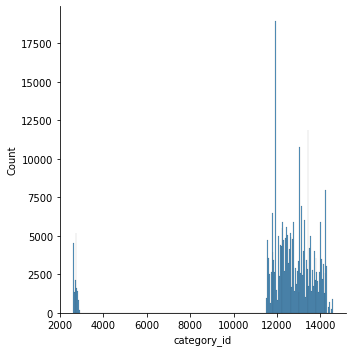

In [12]:
sns.displot(train_df['category_id']);

Как видно из распределения целевого признака - датасет сильно несбалансированный.

### 3. Подготовка текстовых данных

Лемматизацию тектовых признаков будем проводить с использованием библиотеки pymorphy2. 

In [13]:
russian_stopwords = stopwords.words("russian")
blacklist = set(punctuation)

morph = pymorphy2.MorphAnalyzer()

Для обработки будет использоваться следующая функция.

In [14]:
def lemmatize(text: str) -> str:
    """returns a list, consisting of the lemmas from the input string"""
    words = text.split() # разбиваем текст на слова
    res = set() 
    for word in words:
        word = ''.join(c for c in word if (c not in blacklist and c.isdigit()==False)) #удаляем знаки препинания и цифры
        if len(word)>=3: #для всех слов, состоящих из трех и более букв, во множество ответов записываем нормальную форму слова
            word = morph.parse(word)[0].normal_form
            res.add(word)

    return (' ').join(res) #возвращаем ответ в виде строки. 
#Ответ накапливался в форме множества, чтобы удалить повторяющиеся элементы

Для обучения классификатора будут использоваться столбцы 'title' и 'short description'. Объединим эти столбцы в один столбец 'corpus'.

Анализ ошибок классификации на тренировочной выборке показал, что в текстовых описаниях товаров встречаются слова, разделенные дефисами и слэшами, которые из-за этого неправильно обрабатываются функцией lemmatize. Заменим эти символы на пробелы.  

In [15]:
train_df['corpus'] = train_df['title'] + ' ' + train_df['short_description']
train_df['corpus'] = train_df['corpus'].str.replace('-', ' ')
train_df['corpus'] = train_df['corpus'].str.replace('/', ' ')

In [16]:
%%time
train_df['corpus'] = train_df['corpus'].apply(lemmatize)

CPU times: total: 7min 31s
Wall time: 7min 32s


In [18]:
pd.set_option('display.max_colwidth',100)

Посмотрим на обработаный текст

In [19]:
train_df['corpus'].sample(10)

124256                                                        для солнце плёнка солнцезащитный тонировка окно
170098                                                                                              фоторамка
250658                    для зубной принадлежность крышка футляр пастыкосметикиаксессуар стакан ванная щётка
166644                                                    материал микки принтом хлопок футболка женский маус
56694                                                   для подарок дизайн подарочный новогодний размер пакет
133359                                       для кожа ключ органайзер корзина искуственный хранение аксессуар
263210                                                                                    магнитный держатель
39736                                                                                   детский принтом носка
279844             ткань работа костюмный цвет бабочка ручной галстук классический классика однотонный чёрный
177149    

In [20]:
X = train_df['corpus'] #матрица признаков
y = train_df['category_id'] # целевой вектор

### 4. Обучение модели

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

В качестве baseline, для решения задачи мультиклассовой классификации данных по текстовым признакам будем использовать метод Комплементарного Наивного Байеса (модифицированный Наивный Байес, в котором учитываются веса классов) над мешком слов.
Модель обучается на частотных векторах слов, полученных с помощью TfidfVectorizer. Применяем стратифицированную кросс валидацию т.к. целевой признак имеет несбалансированное распределение

Иерархический F1-score будем считать с помощью следующих функций:

In [ ]:
def intersect_paths(path_true, path_pred) -> int:
    """returns amount of equal elements in the paths of the predicted and true target values"""
    _auxset = set(path_true)
    intersection = [x for x in path_pred if x in _auxset]
    return len(intersection)


def calculate_hF(true_paths: list, pred_paths: list) -> float:
    """return the hF1 score for the paths of the predicted and true target values"""
    sum_P, sum_T, sum_PT = 0,0,0
    
    for i in range(len(true_paths)):
        sum_T+=len(true_paths[i])
        sum_P+=len(pred_paths[i])
        sum_PT += intersect_paths(true_paths[i], pred_paths[i])
        hP, hR = sum_PT / sum_P, sum_PT / sum_T
        
    return 2*hP*hR/(hP+hR)

Baseline. Stratified k-Fold Cross Validation for Naive Bayes 

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

text_clf = Pipeline([('tfidf', TfidfVectorizer(max_features= 10000, ngram_range = (1,1), stop_words = russian_stopwords, analyzer = 'word')), 
                    ('clf', ComplementNB())])

In [25]:
%%time
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    text_clf.fit(X_train, y_train.values)

c:\users\kate\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CPU times: total: 40.8 s
Wall time: 41.3 s


In [26]:
%%time
y_pred = text_clf.predict(X)
        
true_paths = [get_path(y) for y in y.values]
pred_paths = [get_path(y) for y in y_pred]
hF1 = calculate_hF(true_paths, pred_paths)        
print('Baseline hF1 = ', hF1)

Baseline hF1 =  0.8327339044780493
CPU times: total: 30min 56s
Wall time: 31min 2s


Модель Linear Support Vector Classification 

In [28]:
text_clf2 = Pipeline([('tfidf', TfidfVectorizer(max_features= 10000, ngram_range = (1,1), stop_words = russian_stopwords, analyzer = 'word')), 
                    ('clf', LinearSVC(random_state = 1))])

In [30]:
%%time
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    text_clf2.fit(X_train, y_train.values)

c:\users\kate\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CPU times: total: 34min 12s
Wall time: 34min 19s


In [31]:
%%time
y_pred = text_clf2.predict(X)
        
true_paths = [get_path(y) for y in y.values]
pred_paths = [get_path(y) for y in y_pred]
        
hF1 = calculate_hF(true_paths, pred_paths)
print('LinearSVC hF1 = ', hF1)

LinearSVC hF1 =  0.9539726320244458
CPU times: total: 30min 58s
Wall time: 41min 5s


Посмотрим, на каких элементах происходит ошибка классификации

In [143]:
df = pd.DataFrame()
df['description'] = train_df['title']
df['y_true'] = train_df['category_id']
df['y_pred'] = y_pred
df.head()

,description,y_true,y_pred
0,Muhle Manikure Песочные колпачки для педикюра 1015 PW Средний (150 грит) (упаковка 10 шт),2693,2693
1,"Sony Xperia L1 Защитное стекло 2,5D",13408,13408
2,"Конверт для денег Прекрасная роза, 16,5 х 8 см",11790,11790
3,Серьги,14076,13061
4,Наклейки на унитаз для туалета на крышку бачок на дверь ванную на стену мебель зеркало,12401,12401


In [144]:
df = df[df['y_true']!=df['y_pred']]

In [145]:
def misclassification(df):
    df = df.sample(5)
    for i in range(5):
        print('Описание: ', df['description'].values[i])
        print('Путь: ', get_text_path(int(df['y_true'].values[i])))
        print('Предсказание: ', get_text_path(df['y_pred'].values[i]))
        print()

In [146]:
misclassification(df)

Описание:  Чокер со звездами
Путь:  Все категории -> Аксессуары -> Аксессуары для девочек -> Бижутерные украшения -> Украшения на шею
Предсказание:  Все категории -> Аксессуары -> Женские аксессуары -> Бижутерные украшения -> Украшения на шею -> Чокеры

Описание:  Комплект женский с брюками LILIANS
Путь:  Все категории -> Одежда -> Женская одежда -> Домашняя одежда -> Пижамы
Предсказание:  Все категории -> Одежда -> Женская одежда -> Домашняя одежда -> Комплекты

Описание:  Халайтеры+нежные румяна
Путь:  Все категории -> Красота -> Макияж -> Лицо -> Палетки для контуринга
Предсказание:  Все категории -> Красота -> Макияж -> Лицо -> Румяна и бронзеры

Описание:  Бантик
Путь:  Все категории -> Аксессуары -> Женские аксессуары -> Аксессуары для волос -> Резинки
Предсказание:  Все категории -> Аксессуары -> Аксессуары для девочек -> Аксессуары для волос -> Резинки

Описание:  Серьга-обманка кольцо  с крестом унисекс / серьги клипсы
Путь:  Все категории -> Аксессуары -> Мужские аксессуары -

Чаще всего ошибки классификации возникают из-за категорий с одинаковыми названиями в ветках женских/мужских/детских товаров, когда по текстовому описанию невозможно правильно отнести товар к нужной ветке. 

Например

Описание:  Чокер со звездами

Путь:  Все категории -> Аксессуары -> Аксессуары для девочек -> Бижутерные украшения -> Украшения на шею

Предсказание:  Все категории -> Аксессуары -> Женские аксессуары -> Бижутерные украшения -> Украшения на шею -> Чокеры

GridSearchCV

Лучшие параметры выбранной модели можно найти с помощью поиска по сетке параметров с кросс-валидацией. Из-за ограниченности вычислительных ресурсов - оптимизация не проводилась.

In [ ]:
parameters = [{
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (10000, 30000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  
    'clf__C': (1, 10, 100)
}]

In [ ]:
grid_search = GridSearchCV(text_clf1, parameters, cv=skf.split(X,y))
grid_search.fit(X, y)

In [100]:
best_text_clf = grid_search.best_estimator_

### 5. Загрузка тестовой выборки

In [32]:
test_df = pd.read_parquet('test.parquet', engine = 'pyarrow')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          70864 non-null  int64  
 1   title                       70864 non-null  object 
 2   short_description           33346 non-null  object 
 3   name_value_characteristics  12576 non-null  object 
 4   rating                      70864 non-null  float64
 5   feedback_quantity           70864 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 3.2+ MB


In [33]:
test_df.isnull().sum()

id                                0
title                             0
short_description             37518
name_value_characteristics    58288
rating                            0
feedback_quantity                 0
dtype: int64

In [34]:
test_df.fillna(value = ' ', inplace = True)
test_df['corpus'] = test_df['title'] + ' ' + test_df['short_description']
test_df['corpus'] = test_df['corpus'].str.replace('-', ' ')
test_df['corpus'] = test_df['corpus'].str.replace('/', ' ')

In [35]:
%%time
test_df['corpus'] = test_df['corpus'].apply(lemmatize)

CPU times: total: 1min 52s
Wall time: 1min 53s


In [36]:
y_test_pred = text_clf2.predict(test_df['corpus'])
test_df['category_id'] = y_test_pred

In [38]:
test_df.sample(10)

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,corpus,category_id
10227,454313,Защитное стекло премиум для Iphone 12 Pro Max/ Айфон 12 про макс,,,0.000000,0,премиум для max iphone макс защитный айфон про стекло pro,13408
23035,985603,Трусы женские Clever классические,Трусы женские Clever классические,,0.000000,0,женский трус clever классический,14233
69627,1088820,Туника женская Блеск,Легкая и комфортная туника из хлопка с принтом.,Российский размер одежды:44|46|48|50|52|54|56|58|60|62|64|66,0.000000,0,комфортный блеск хлопок лёгкий принтом женский туника,12024
57999,1403473,"Молд силиконовый ""Листья""",,,0.000000,0,силиконовый лист молд,12841
51714,725081,"DNC Масло дикого манго для бровей и ресниц, 12 мл",,,0.000000,0,ресница для dnc бровь манго масло дикий,12558
59751,499718,Подставка для телефона компактная универсальная,Держатель-подставка для телефона,,4.000000,2,для универсальный держатель подставка телефон компактный,14241
58218,270886,"Защитная накладка на камеру для iPhone 11 Pro / 11 Pro Max, 10 цветов","Накладка защитит камеру вашего смартфона от царапин, потертостей и других повреждений при эксплу...",,2.333333,3,накладка эксплуатация для другой max iphone цвет ваш смартфон царапина защитный защитить потёрто...,13408
7874,611790,Серьги женские прямоугольные,Серьги женские прямоугольные со стразами,,5.000000,2,женский серьга страз прямоугольный,13061
46457,924175,Щипцы-ложка кухонные 25 см,,,4.571429,14,ложка кухонный щипец,14011
56540,1065082,Серьги - талисманы . Долголетие и защита (черепаха) цвет серебро,"Защитные талисманы всегда с вами серьги. Помощники и защитники, талисманы оберегают от зла и при...",,0.000000,0,серебро защита находиться защитник они долголетие серьга цвет помощник защитный оберегать принос...,11617


Посмотрим на результаты с помощью следующей функции:

In [39]:
def print_results():
    df = test_df.sample(10)
    for i in range(10):
        print('Описание: ',df['title'].values[i])
        print('Путь: ', get_text_path(df['category_id'].values[i]))
        print()

In [46]:
print_results()

Описание:  Чехол накладка для Nokia 2
Путь:  Все категории -> Электроника -> Смартфоны и телефоны -> Аксессуары и запчасти -> Чехлы

Описание:  Пинетки интерлок для новорожденного (меланж)
Путь:  Все категории -> Одежда -> Одежда для новорождённых -> Носки, пинетки

Описание:  Женский рюкзак
Путь:  Все категории -> Аксессуары -> Женские аксессуары -> Сумки и рюкзаки -> Рюкзаки

Описание:  Аккумулятор Prestigio 4020
Путь:  Все категории -> Электроника -> Смартфоны и телефоны -> Аксессуары и запчасти -> Аккумуляторы

Описание:  Комплект для мальчика
Путь:  Все категории -> Одежда -> Одежда для мальчиков -> Костюмы и пиджаки -> Комплекты

Описание:  Женский топ, топ-бюстгальтер, топ повседневный, спортивный топ, базовый женский топ
Путь:  Все категории -> Одежда -> Женская одежда -> Белье и купальники -> Бюстгальтеры

Описание:  Куртка мужская LTB
Путь:  Все категории -> Одежда -> Мужская одежда -> Верхняя одежда -> Куртки

Описание:  Боди ТВОЕ
Путь:  Все категории -> Одежда -> Женская од

На первый взгляд, все категории предсказаны правильно... =)

### 6. Вывод решения

In [42]:
submission = pd.DataFrame(index = test_df['id'])
submission['predicted_category_id'] = y_test_pred
submission.head()

,predicted_category_id
id,
1070974,11574
450413,11878
126857,13299
1577569,13061
869328,12813


In [43]:
submission.to_parquet('result.parquet', engine = 'pyarrow')